# Probabilistic Forecasting: Model for Intermitent Demand

In [6]:
import numpy as np 
import pandas as pd
import random 
from intermittent import croston 
from intermittent import adjust_croston
from intermittent import kalman
from intermittent import slow_move
# from intermittent import multistage_glm
import scipy.stats as st 
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
class IntermitentForcaster:

    @staticmethod
    def croston(y, forecast_period):
        fit_pred = croston.fit(y, forecast_period)
        # model setup
        # model = fit_pred['crosto']
        ypred = fit_pred['croston_forecast']
        yfit = fit_pred['croston_fittedvalues']
        return yfit, ypred 
    
    @staticmethod
    def adjust_croston(y, forecast_period, forecast_hyperbolic=True):
        fit_pred = adjust_croston.fit(y, forecast_period, forecast_hyperbolic)
        # model setup
        # model = fit_pred['crosto']
        ypred = fit_pred['croston_forecast']
        yfit = fit_pred['croston_fittedvalues']
        return yfit, ypred 
    
    @staticmethod
    def kalman_filter(y, forecast_period, F=None, H=None, Q=None, R=None):
        dt = 1.0/60
        F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
        H = np.array([1, 0, 0]).reshape(1, 3)
        Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
        R = np.array([0.5]).reshape(1, 1)
        yfit = []
        ypred = []
        kf = kalman.KalmanFilter(F, Q, H, R)
        kf.fit(y)
        for mu in kf.mus:
            yfit.append(H.dot(mu)[0])
        for _ in range(forecast_period):
            ypred.append(H.dot(kf.predict()))
        yfit = np.asarray(yfit).reshape((-1, 1))
        ypred = np.asarray(ypred).reshape((-1, 1))
        return yfit, ypred
    
    @staticmethod
    def kalman_smoother(y, forecast_period, F=None, H=None, Q=None, R=None):
        dt = 1.0/60
        F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
        H = np.array([1, 0, 0]).reshape(1, 3)
        Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
        R = np.array([0.5]).reshape(1, 1)
        yfit = []
        ypred = []
        ks = kalman.KalmanSmoother(F, Q, H, R)
        ks.fit(y)
        for mu in ks.mus:
            yfit.append(H.dot(mu)[0])
        for _ in range(forecast_period):
            ypred.append(H.dot(ks.predict()))
        yfit = np.asarray(yfit).reshape((-1, 1))
        ypred = np.asarray(ypred).reshape((-1, 1))
        return yfit, ypred
    
    @staticmethod
    def slow_mover(y, forecast_period, num_sample_points=200):
        smf = slow_move.SlowMoveForcaster()
        y50, y25, y90 = smf.fit(y)
        ypred, ypred25, ypred90 = [], [], []
        for _ in range(forecast_period):
            p50, p25, p90 = smf.predict(size=num_sample_points)
            ypred.append(p50)
            ypred25.append(p25)
            ypred90.append(p90)
        return y50, ypred

C:\Users\z004775k\Documents\uj3\notebooks\intermittent\slow_move.py:100: RuntimeWarning: invalid value encountered in double_scalars
  logprob = (loggamma(a+y) - loggamma(a) - loggamma(y+1)) + \


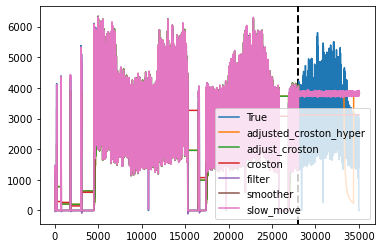

In [17]:
if __name__ == "__main__": 
    data = pd.read_csv("../data/external/LD_MT200_hour.csv", parse_dates=["date"])
    data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)
    data["month"] = data["date"].apply(lambda x: x.month)
    data["year"] = data["date"].apply(lambda x: x.year)
    num_data = len(data)
    train_ratio = 0.8
    train_size = int(num_data * train_ratio)
    test_size = num_data - train_size
    tot_ts = data["Intermittent"]
    X = np.c_[np.asarray(pd.get_dummies(data["day_of_week"])), np.asarray(pd.get_dummies(data["month"]))]
    ts = tot_ts[:train_size]
    forecast_period = test_size
    yfit, ypred = IntermitentForcaster.adjust_croston(ts, forecast_period)
    yhat1 = np.concatenate([yfit, ypred])

    yfit, ypred = IntermitentForcaster.adjust_croston(ts, forecast_period, False)
    yhat2 = np.concatenate([yfit, ypred])

    yfit, ypred = IntermitentForcaster.croston(ts, forecast_period)
    yhat3 = np.concatenate([yfit, ypred])

    yfit, ypred = IntermitentForcaster.kalman_filter(ts, forecast_period)
    yhat4 = np.concatenate([yfit, ypred])

    yfit, ypred = IntermitentForcaster.kalman_smoother(ts, forecast_period)
    yhat5 = np.concatenate([yfit, ypred])

    yfit, ypred = IntermitentForcaster.slow_mover(ts, forecast_period)
    yhat6 = np.concatenate([yfit, ypred])

    plt.plot(tot_ts) 
    plt.plot(yhat1)
    plt.plot(yhat2)
    plt.plot(yhat3)
    plt.plot(yhat4)
    plt.plot(yhat5)
    plt.plot(yhat6)

    plt.legend(["True", "adjusted_croston_hyper", "adjust_croston", "croston", "filter", "smoother", "slow_move"])
    ymin, ymax = plt.ylim()
    plt.vlines(train_size, ymin, ymax, color="k", linestyles="dashed", linewidth=2)
    plt.ylim(ymin, ymax)
    plt.show()